In [1]:
from collections import defaultdict
import glob
from os.path import join
import os
import random
import string
import tarfile
import zipfile

In [2]:
import hnswlib
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import gluon, nd, autograd
import numpy as np
import PIL
from PIL import Image, ImageDraw, ImageFont, ImageOps
from scipy.io import loadmat

In [3]:
from ocr.handwriting_line_recognition import Network as HandwritingRecognitionNet, handwriting_recognition_transform
from ocr.handwriting_line_recognition import decode as decoder_handwriting, alphabet_encoding

# Data Generation

We generate partial text that ressembles cursive using custom fonts angled / slided and of different sizes

In [4]:
ctx= mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu()

In [43]:
fonts = [
    'dataset/fonts/Herr_Von_Muellerhoff/HerrVonMuellerhoff-Regular.ttf',
    'dataset/fonts/Aguafina_Script/AguafinaScript-Regular.ttf',
    'dataset/fonts/Condiment/Condiment-Regular.ttf',
    'dataset/fonts/Devonshire/Devonshire-Regular.ttf',
    'dataset/fonts/Euphoria_Script/EuphoriaScript-Regular.ttf'
]

In [114]:
factors = {
    fonts[0]: {'r':10, 'size':0.5, 'slide':(0.6, 0.2)},
    fonts[1]: {'r':10, 'size':0.55, 'slide':(0.6, 0.2)},
    fonts[2]: {'r':10, 'size':0.4, 'slide':(0.5, 0.2)},
    fonts[3]: {'r':10, 'size':0.55, 'slide':(0.8, 0.2)},
    fonts[4]: {'r':10, 'size':0.55, 'slide':(0.7, 0.2)},
}

Manual Testing of images

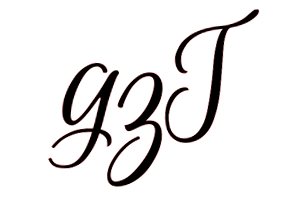

In [119]:
W, H = (300,200)
im = Image.new("RGB",(W,H),"white")
msg = "gzT"
font =  fonts[4]
shift = 0
initial_shit = random.uniform(30, 90)
for i, char in enumerate(msg):    
    size = random.gauss(factors[font]['size'], 0.05*factors[font]['size'] )*W
    im_char = Image.new("RGBA",(W,H), (255, 0, 0, 0))
    draw = ImageDraw.Draw(im_char)
    rotate = random.uniform(-factors[font]['r'], factors[font]['r'])
    font_ = ImageFont.truetype(font, size=int(size))
    slide = random.uniform(factors[font]['slide'][0]-factors[font]['slide'][1],factors[font]['slide'][0]+factors[font]['slide'][1])
    w, h = draw.textsize(char, font_)
    draw.text((initial_shit + shift,0), char, fill="black", font=font_)
    im_char = im_char.rotate(rotate, expand=0, resample=PIL.Image.BICUBIC)
    im.paste(im_char, mask=im_char)
    shift += slide*w
im

In [120]:
class FontDataset(gluon.data.Dataset):
    def __init__(self, font=fonts[3],
                  ngrams=3, size=(300, 200), out_channel=1):
        self.font = font
        self.ngrams = ngrams
        self.alphabet = list(' ' + string.ascii_letters + string.digits+"'.,;:\"()?!")
        self.elements = self.alphabet
        self.size = size
        self.out_channel = out_channel
        for i in range(self.ngrams-1):
            elements_ = []
            for word in self.elements:
                for letter in self.alphabet:
                    elements_.append(word+letter)
            self.elements = elements_
        a = 1
        
    def _get_img(self, text, font=None):
        W, H = self.size
        if font is None:
            font = self.font
            font_ = ImageFont.truetype(self.font, size=120)
        else:
            font_ = ImageFont.truetype(font, size=60)
        im = Image.new("RGB",(W,H),"white")
        shift = 0
        initial_shit = random.uniform(0.1*W, 0.3*W)
        for i, char in enumerate(text):    
            size = random.gauss(factors[font]['size'], 0.05*factors[font]['size'] )*W
            im_char = Image.new("RGBA",(W,H), (255, 0, 0, 0))
            draw = ImageDraw.Draw(im_char)
            rotate = random.uniform(-factors[font]['r'], factors[font]['r'])
            font_ = ImageFont.truetype(font, size=int(size))
            slide = random.uniform(factors[font]['slide'][0]-factors[font]['slide'][1],factors[font]['slide'][0]+factors[font]['slide'][1])
            w, h = draw.textsize(char, font_)
            draw.text((initial_shit + shift,0), char, fill="black", font=font_)
            im_char = im_char.rotate(rotate, expand=0, resample=PIL.Image.BICUBIC)
            im.paste(im_char, mask=im_char)
            shift += slide*w
        return im
            
    def __getitem__(self, idx):
        text = self.elements[idx]
        im = self._get_img(text)
        if self.out_channel == 3:
            return nd.array(np.array(im)), idx
        else:
            return nd.array(np.array(im).mean(axis=2)).expand_dims(axis=2), idx
        
    def __len__(self):
        return len(self.elements)    

In [121]:
train_dataset = FontDataset()
batch_size = 64
train_data = gluon.data.DataLoader(train_dataset.transform_first(gluon.data.vision.transforms.ToTensor()), batch_size=batch_size, last_batch='rollover', shuffle=True, num_workers=8)

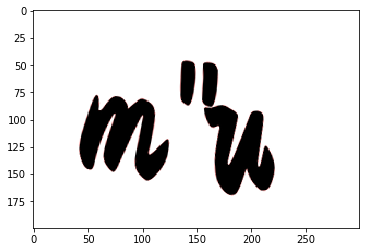

In [123]:
plt.imshow(train_dataset._get_img('m"u'), cmap='gray')

## Using the pre-trained recognition network

In [125]:
handwriting_line_recognition_net = HandwritingRecognitionNet(rnn_hidden_states=512,
                                                             rnn_layers=2, ctx=ctx, max_seq_len=160)
handwriting_line_recognition_net.load_parameters("models/handwriting_line8.params", ctx=ctx)

In [142]:
im = np.array(train_dataset._get_img('cow'))

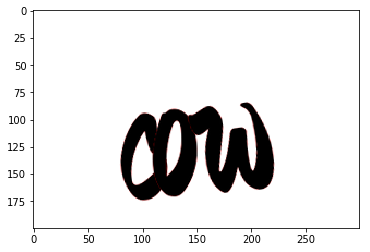

In [143]:
plt.imshow(im)

In [144]:
line_image_size = (60, 800)
line_image = handwriting_recognition_transform(np.array(im).mean(axis=2), line_image_size)
line_character_prob = handwriting_line_recognition_net(line_image.as_in_context(ctx))

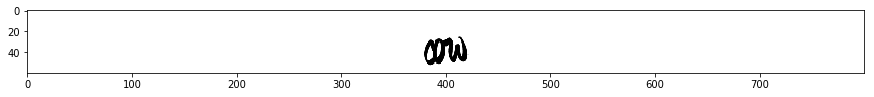

In [145]:
plt.figure(figsize=(15,15))
plt.imshow(line_image[0,0,:,:].asnumpy(), cmap='gray')

In [146]:
from ocr.utils.CTCDecoder.BeamSearch import ctcBeamSearch

In [147]:
def get_beam_search(prob, width=20, k=10):
    possibilities = ctcBeamSearch(line_character_prob.softmax()[0].asnumpy(), alphabet_encoding, None, width, k)
    return possibilities

In [148]:
get_beam_search(line_character_prob)

['cow',
 'coow',
 'co',
 'cows',
 'coo',
 'coows',
 'cnow',
 'cou',
 'cowd',
 'cvow',
 'cow.',
 'coow.',
 'co.',
 'cows.',
 'coo.',
 'coows.',
 'cnow.',
 'cou.',
 'cowd.',
 'cvow.']

**Problem:** The network has already learnt a language model that biases the result towards realistic looking syllables

## Testing a pre-trained network

In [149]:
net = mx.gluon.model_zoo.vision.resnet18_v2(pretrained=True, ctx=ctx).features

In [150]:
net.hybridize()

In [151]:
batch_size = 128
dim = 512
tf = gluon.data.vision.transforms.ToTensor()

In [152]:
%%time
j = 0
num_iterations = 4
outputs = []
for font in fonts:

    train_dataset = FontDataset(ngrams=2, out_channel=3, font=font)
    train_data = gluon.data.DataLoader(train_dataset.transform_first(tf), batch_size=batch_size, shuffle=False, num_workers=8)

    for k in range(num_iterations):
        print(j)
        j += 1
        for i, (data, _) in enumerate(train_data):
            data = data.as_in_context(ctx)
            output = net(data)
            #embeddings[i*batch_size:(i+1)*batch_size, :] += output.squeeze().asnumpy()
            for out in output.squeeze().asnumpy().reshape(-1, 512):
                outputs.append(out)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
CPU times: user 42.9 s, sys: 32.1 s, total: 1min 14s
Wall time: 4min 26s


In [153]:
def get_index(dim, embeddings, num_elements):
    # Generating sample data
    data = np.float32(np.random.random((num_elements, dim)))
    data_labels = np.arange(num_elements)

    # Declaring index
    p = hnswlib.Index(space = 'l2', dim = dim) # possible options are l2, cosine or ip

    # Initing index - the maximum number of elements should be known beforehand
    p.init_index(max_elements = num_elements, ef_construction = 200, M = 16)

    # Element insertion (can be called several times):
    p.add_items(embeddings, data_labels)

    # Controlling the recall by setting ef:
    p.set_ef(50) # ef should always be > k
    return p

In [154]:
p = get_index(dim, np.concatenate([arr.reshape(1, -1) for arr in outputs]), len(outputs))

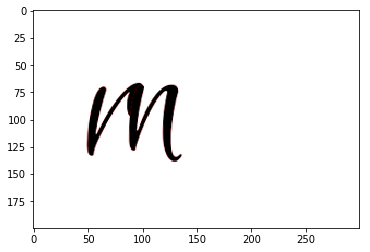

In [183]:
# Query dataset, k - number of closest elements (returns 2 numpy arrays)
img_ =  FontDataset(ngrams=2, out_channel=3, font=fonts[random.randint(0,len(fonts)-1)])._get_img("rn")
plt.imshow(img_)

In [185]:
img = nd.array(np.array(img_))
output = net(tf(img).as_in_context(ctx).expand_dims(axis=0)).squeeze().asnumpy()
labels, distances = p.knn_query(output, k = 20)
[(train_dataset.elements[int(i%len(train_dataset))],d) for i,d in zip(labels[0],distances[0])]

[('m,', 6.9569373),
 ('rn', 7.5215664),
 ('nn', 7.833893),
 ('m ', 8.58198),
 ('nn', 9.298881),
 ('n ', 10.03327),
 ('m.', 10.229692),
 ('rn', 11.013294),
 ('mn', 11.098972),
 ('ra', 11.17969),
 (',m', 11.533644),
 (' m', 11.542616),
 ('ra', 11.563443),
 ('nn', 11.851172),
 ('.m', 12.124906),
 ('mm', 12.234188),
 ('n ', 12.258422),
 (' n', 12.284981),
 ('nq', 12.339354),
 ('m:', 12.507874)]

### Post Processing TBD